# User Churn Prediction

**In** this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
</ul>

# Part 0: Setup Google Drive Environment

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 4.8MB/s 


In [0]:
file = drive.CreateFile({'id':'1BmXe8XIPvbghz7kMEjmt9vBX8LZbX4Jq'}) # replace the id with id of file you want to access
file.GetContentFile('churn.all')

**Homework 0: Use the recommended way to load data.**

In [0]:
####
## Your Code
####
import pandas as pd
file_id='1BmXe8XIPvbghz7kMEjmt9vBX8LZbX4Jq'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
my_data = pd.read_csv(csv_url)

In [4]:
my_data.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import imblearn
# will show all the columns
pd.set_option('display.max_columns', None)

churn_df = pd.read_csv('churn.all')

In [0]:
#@title *Bonus (不需要掌握): The Iris dataset in sklearn*
from sklearn import datasets
iris = datasets.load_iris()

print(type(iris)) # bunch like dictionary
print(iris.keys())

X = iris.data
y = iris.target
df = pd.DataFrame(X, columns=iris.feature_names)
print(df.head())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [0]:
churn_df.head()
# churn_df.info()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [0]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


### Part 1.2: Data cleaning

Remove Extra Whitespace

In [0]:
# check categorical feature
churn_df['voice_mail_plan'][0]

' yes'

In [0]:
# remove the heading and trailing whitespaces
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].map(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].map(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].map(lambda x: x.strip())

In [0]:
# check the categorical feature after manipulation
churn_df['voice_mail_plan'][0]

'yes'

### Part 1.3:  Understand the features

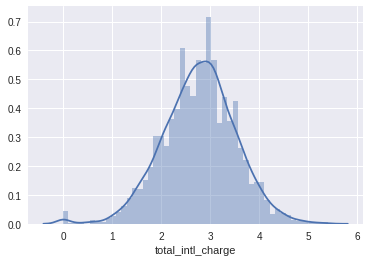

In [0]:
# check the feature distribution
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(churn_df['total_intl_charge'], kde=True)

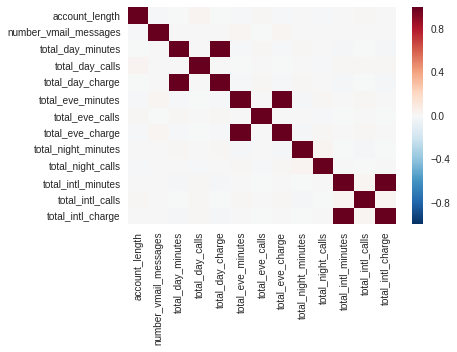

In [0]:
# correlations between all the features
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

# show heapmap of correlations
sns.heatmap(corr)

In [0]:
# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.000391,-0.000156,0.000368


In [0]:
# calculate two features correlation
from scipy.stats import pearsonr
print (pearsonr(churn_df['total_day_minutes'], churn_df['number_vmail_messages'])[0])

0.005381375960654535


# Part 2: Feature Preprocessing

In [0]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [0]:
# Get ground truth data
y = np.where(churn_df['churned'] == 'True.',1,0)

# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

X = churn_feat_space

In [0]:
X

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
5,118,True,False,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
6,121,False,True,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3
7,147,True,False,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0
8,117,False,False,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
9,141,True,True,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0


In [0]:
# check the propotion of y = 1
print(y.sum() / y.shape * 100)

[14.14]


#### Homework 1: Can you add catogorical features, e.g. state, into your feature matrix?

Read more for handling [categorical feature](https://github.com/scikit-learn-contrib/categorical-encoding)

In [0]:
####
## Your Code
####

to_drop_hw1 = ['area_code','phone_number','churned']
churn_feat_space_hw1 = churn_df.drop(to_drop_hw1, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space_hw1[yes_no_cols] = churn_feat_space_hw1[yes_no_cols] == 'yes'

churn_feat_space_hw1 = pd.get_dummies(churn_feat_space_hw1, columns=['state'])

churn_feat_space_hw1.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))
print (pd.DataFrame(X).head())

Feature space holds 5000 observations and 17 features
Unique target labels: [0 1]
         0         1         2         3         4         5         6   \
0  0.698941 -0.323240  1.667120  1.273145  1.573802  0.502824  1.574074   
1  0.169849 -0.323240  1.667120  1.346973 -0.346802  1.158422 -0.347082   
2  0.925695 -0.323240 -0.599837 -0.572549  1.171125  0.704546  1.171286   
3 -0.409634  3.093675 -0.599837 -0.572549  2.210292 -1.463971  2.210457   
4 -0.636388  3.093675 -0.599837 -0.572549 -0.252163  0.654116 -0.252115   

         7         8         9         10        11        12        13  \
0 -0.064032 -0.060077 -0.063849  0.876999 -0.446928  0.876286 -0.094809   
1 -0.101621  0.141693 -0.101089  1.068992  0.154374  1.069818  1.245227   
2 -1.571562  0.494791 -1.572084 -0.748012  0.204483 -0.746737  0.701969   
3 -2.744745 -0.614946 -2.745155 -0.069110 -0.547145 -0.069377 -1.326194   
4 -1.035419  1.100103 -1.034426 -0.267041  1.056327 -0.267307 -0.058592   

         14     

In [0]:
X

array([[ 0.69894149, -0.32324017,  1.66712012, ..., -0.58423577,
        -0.0955088 , -0.43667564],
       [ 0.16984882, -0.32324017,  1.66712012, ..., -0.58423577,
         1.24598231, -0.43667564],
       [ 0.92569549, -0.32324017, -0.5998368 , ...,  0.22991664,
         0.69597096, -1.20223603],
       ...,
       [-0.98911606, -0.32324017, -0.5998368 , ..., -0.17715957,
         1.20573758, -0.43667564],
       [ 0.2202386 , -0.32324017, -0.5998368 , ...,  0.63699285,
        -0.63210525, -1.20223603],
       [-0.35924384, -0.32324017,  1.66712012, ...,  4.70775494,
        -0.35039211, -1.20223603]])

# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [0]:
# Splite data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 17 features
test data has 1000 observation with 17 features


### Part 3.2: Model Training and Selection

In [0]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [0]:
# Train the model
classifier_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# Prediction of test data
classifier_logistic.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

0.862

In [0]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    # cprint(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

Model accuracy of Logistic Regression is: 0.868
Model accuracy of KNN is: 0.896
Model accuracy of Random Forest is: 0.948


#### Homework 2: Can you do prediction with SVM model?

In [0]:
####
## Your Code
####
# SVC
from sklearn.svm import SVC 

classifier_SVC = SVC()

cv_score = model_selection.cross_val_score(classifier_SVC, X_train, y_train, cv=5)
print('Model accuracy of SVM is: %.3f'%(cv_score.mean()))


Model accuracy of SVM is: 0.923


### (Optional) Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [0]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.868
Best parameters set:
	C: 10
	penalty: 'l1'


In [0]:
# best model
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [0]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.896
Best parameters set:
	n_neighbors: 5


#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [0]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 60, 80]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.955
Best parameters set:
	n_estimators: 80


In [0]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.966
precision is: 0.976
recall is: 0.799


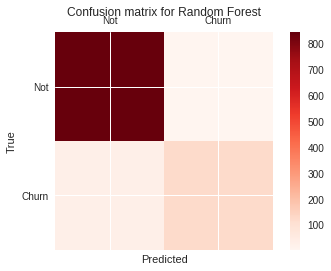

Logistic Regression
Accuracy is: 0.863
precision is: 0.649
recall is: 0.240


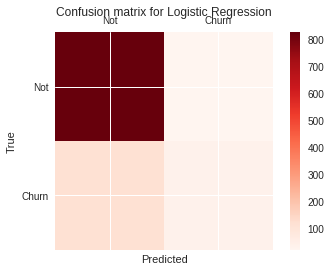

In [0]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC of RF Model

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

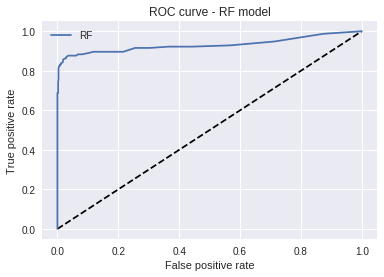

In [0]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [0]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.9312578674280803

#### Part 3.4.1: ROC of LR Model

In [0]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

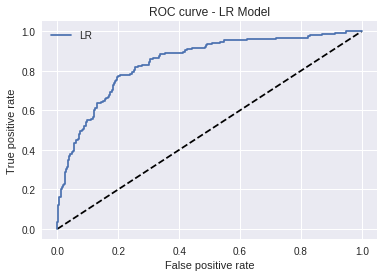

In [0]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [0]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8458444628657394

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

In [0]:
# add L1 regularization to logistic regression
# check the coef for feature selection
LRmodel_l1 = LogisticRegression(penalty="l1")
LRmodel_l1.fit(X, y)
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L1) Coefficients
voice_mail_plan: -0.8657
total_day_charge: 0.6775
number_customer_service_calls: 0.673
intl_plan: 0.613
number_vmail_messages: 0.396
total_eve_minutes: 0.2435
total_intl_charge: 0.2083
total_intl_calls: -0.1743
total_night_charge: 0.1721
total_eve_charge: 0.1143
total_day_minutes: 0.0569
account_length: 0.0534
total_day_calls: 0.0495
total_intl_minutes: 0.0351
total_night_minutes: 0.0296
total_night_calls: -0.0288
total_eve_calls: -0.0284


In [0]:
# add L2 regularization to logistic regression
# check the coef for feature selection
LRmodel_l2 = LogisticRegression(penalty="l2")
LRmodel_l2.fit(X, y)
LRmodel_l2.coef_[0]
print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
  

Logistic Regression (L2) Coefficients
voice_mail_plan: -0.8929
number_customer_service_calls: 0.6731
intl_plan: 0.6132
number_vmail_messages: 0.4234
total_day_minutes: 0.3687
total_day_charge: 0.3664
total_eve_charge: 0.18
total_eve_minutes: 0.1794
total_intl_calls: -0.1761
total_intl_charge: 0.1235
total_intl_minutes: 0.1217
total_night_minutes: 0.1028
total_night_charge: 0.1008
account_length: 0.0552
total_day_calls: 0.0513
total_night_calls: -0.0307
total_eve_calls: -0.0304


### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [0]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_day_minutes: 0.1756
number_customer_service_calls: 0.1125
total_day_charge: 0.1067
intl_plan: 0.0786
total_eve_minutes: 0.071
total_intl_calls: 0.065
total_eve_charge: 0.0578
total_intl_minutes: 0.0526
total_night_minutes: 0.0388
total_night_charge: 0.0376
account_length: 0.0333
voice_mail_plan: 0.0326
total_intl_charge: 0.0315
total_day_calls: 0.028
number_vmail_messages: 0.027
total_eve_calls: 0.0258
total_night_calls: 0.0257
